### Import required libraries

In [1]:
### Imports and Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform

### Loading dataset

In [2]:
def load_dataset(model_type):
    if model_type == "Decision Tree":
        df = pd.read_csv("preprocessed_incident_event_decision_tree.csv")
        df = df.drop(columns=['number_enc'])  # Remove the column only for Decision Tree
    elif model_type in ["SVR", "MLP"]:
        df = pd.read_csv("preprocessed_incident_event_scaled_svm_mlp.csv")
    else:
        raise ValueError("Unknown model type provided.")

    df = df.dropna(subset=["time_to_resolution_log"])
    df = df.dropna()
    return df

### Training and evaluate function

In [3]:
from sklearn.utils import resample

def train_and_evaluate_model(model_name, pipeline, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n Starting training for {model_name}...")
    start_time = time.time()

    if model_name == "SVR":
        # Use a subset for both tuning AND final training to save time
        X_sample, y_sample = resample(X_train, y_train, n_samples=int(0.3 * len(X_train)), random_state=42)
        n_iter = 5
    else:
        X_sample, y_sample = X_train, y_train
        n_iter = 10

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    search.fit(X_sample, y_sample)
    best_params = search.best_params_

    # Retrain final model
    if model_name == "SVR":
        print(f" Re-training {model_name} on 30% subset again to avoid long runtime...")
        final_X, final_y = X_sample, y_sample
    else:
        print(f" Re-training {model_name} on full training data...")
        final_X, final_y = X_train, y_train

    pipeline.set_params(**best_params)
    pipeline.fit(final_X, final_y)
    y_pred = pipeline.predict(X_test)

    # Evaluation
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    model_filename = f"{model_name.replace(' ', '_').lower()}_best_model.pkl"
    joblib.dump(pipeline, model_filename)
    print(f" Saved best model to {model_filename}")

    end_time = time.time()
    print(f" Finished training {model_name} in {(end_time - start_time):.2f} seconds")

    return {
        'name': model_name,
        'model': pipeline,
        'mae': mae,
        'rmse': np.sqrt(mse),
        'r2': r2,
        'y_pred': y_pred,
        'params': best_params,
        'X_test': X_test,
        'y_test': y_test
    }


## Defining 'main' function

In [4]:
def main():
    results = []

    # ---------- Decision Tree ----------
    df_dt = load_dataset("Decision Tree")
    y_dt = df_dt['time_to_resolution_log']
    X_dt = df_dt.drop(columns=['time_to_resolution_log'])
    X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.2, random_state=42)

    dt_pipeline = Pipeline([
        ('dt', DecisionTreeRegressor(random_state=42))
    ])
    dt_params = {
        'dt__max_depth': randint(5, 20),
        'dt__min_samples_split': randint(2, 10),
        'dt__min_samples_leaf': randint(1, 10),
        'dt__criterion': ['squared_error', 'friedman_mse']
    }
    results.append(train_and_evaluate_model("Decision Tree", dt_pipeline, dt_params, X_train, y_train, X_test, y_test))

    # ---------- SVR ----------
    df_svr = load_dataset("SVR")
    y_svr = df_svr['time_to_resolution_log']
    X_svr = df_svr.drop(columns=['time_to_resolution_log'])
    X_train, X_test, y_train, y_test = train_test_split(X_svr, y_svr, test_size=0.2, random_state=42)

    svr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR())
    ])
    svr_params = {
        'svr__C': uniform(0.1, 2),                # Narrowed range
        'svr__epsilon': uniform(0.01, 0.2),
        'svr__kernel': ['linear'],                # ✅ MUCH faster
        'svr__gamma': ['scale']                   # Required for compatibility
    }
    results.append(train_and_evaluate_model("SVR", svr_pipeline, svr_params, X_train, y_train, X_test, y_test))

    # ---------- MLP ----------
    df_mlp = load_dataset("MLP")
    y_mlp = df_mlp['time_to_resolution_log']
    X_mlp = df_mlp.drop(columns=['time_to_resolution_log'])
    X_train, X_test, y_train, y_test = train_test_split(X_mlp, y_mlp, test_size=0.2, random_state=42)

    mlp_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(
            max_iter=500,
            early_stopping=True,
            validation_fraction=0.1,
            random_state=42
        ))
    ])
    mlp_params = {
        'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'mlp__activation': ['relu', 'tanh'],
        'mlp__alpha': uniform(0.0001, 0.01),
        'mlp__learning_rate': ['constant', 'adaptive']
    }
    results.append(train_and_evaluate_model("MLP", mlp_pipeline, mlp_params, X_train, y_train, X_test, y_test))

    return results




### Invoking main function

In [5]:
results = main()


 Starting training for Decision Tree...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
 Re-training Decision Tree on full training data...
 Saved best model to decision_tree_best_model.pkl
 Finished training Decision Tree in 4.29 seconds

 Starting training for SVR...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
 Re-training SVR on 30% subset again to avoid long runtime...
 Saved best model to svr_best_model.pkl
 Finished training SVR in 343.75 seconds

 Starting training for MLP...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
 Re-training MLP on full training data...
 Saved best model to mlp_best_model.pkl
 Finished training MLP in 102.33 seconds


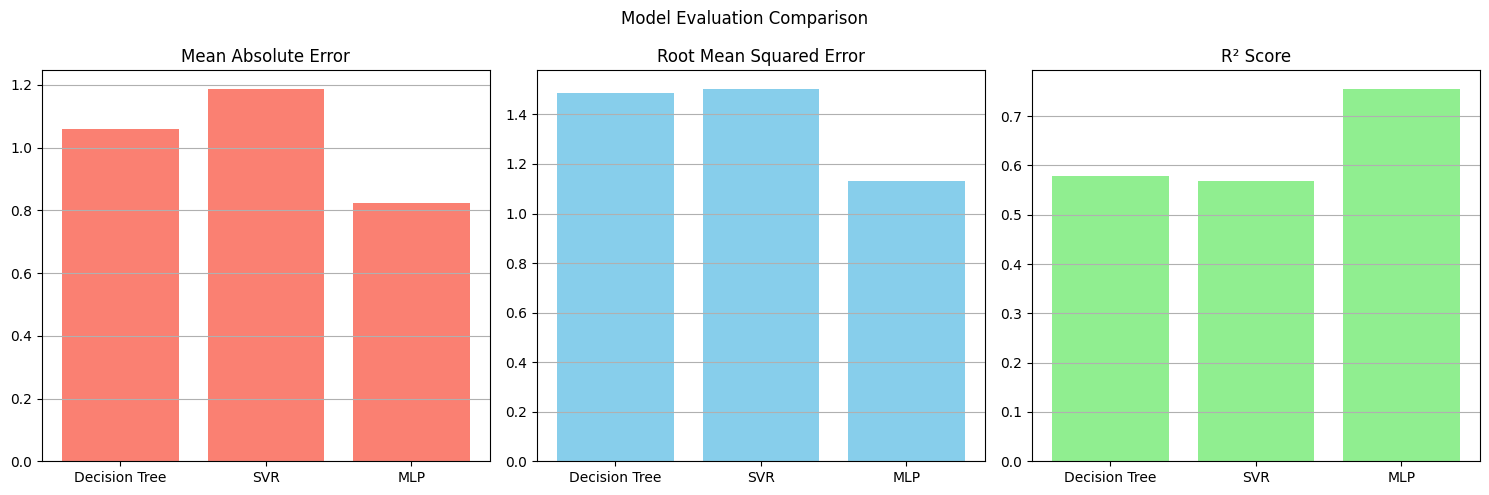

In [6]:
model_names = [r['name'] for r in results]
maes = [r['mae'] for r in results]
rmses = [r['rmse'] for r in results]
r2s = [r['r2'] for r in results]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].bar(model_names, maes, color='salmon')
ax[0].set_title('Mean Absolute Error')
ax[1].bar(model_names, rmses, color='skyblue')
ax[1].set_title('Root Mean Squared Error')
ax[2].bar(model_names, r2s, color='lightgreen')
ax[2].set_title('R² Score')
for i in range(3):
    ax[i].grid(True, axis='y')
plt.suptitle("Model Evaluation Comparison")
plt.tight_layout()
plt.show()


### Model Evaluation Summary

**1. Mean Absolute Error (MAE):**  
- **MLP** performed the best with the **lowest MAE (~0.83)**, indicating its predictions are closest to the actual values on average.  
- **SVR** showed the highest MAE (~1.19), suggesting less accurate individual predictions.

**2. Root Mean Squared Error (RMSE):**  
- **MLP** again achieved the **lowest RMSE (~1.13)**, confirming fewer large errors.  
- Both **Decision Tree** and **SVR** had higher RMSE values (~1.50), reflecting greater spread in error magnitudes.

**3. R² Score:**  
- **MLP** outperformed the others with an R² of **~0.75**, explaining approximately 75% of the variance in the target variable.  
- **Decision Tree** and **SVR** had comparable R² scores (~0.57), indicating limited explanatory power.

---

### Takeaway

> **MLP (Multi-Layer Perceptron)** delivered the best overall performance across all metrics.  
> Its strength in capturing non-linear relationships makes it the most suitable model for predicting `time_to_resolution_log` in this task.



📊 Model Evaluation Metrics Summary:


,name,mae,rmse,r2
0,Decision Tree,1.057992,1.487665,0.578758
1,SVR,1.186939,1.502836,0.568220
2,MLP,0.823386,1.131720,0.755141



 Permutation Importance for Decision Tree


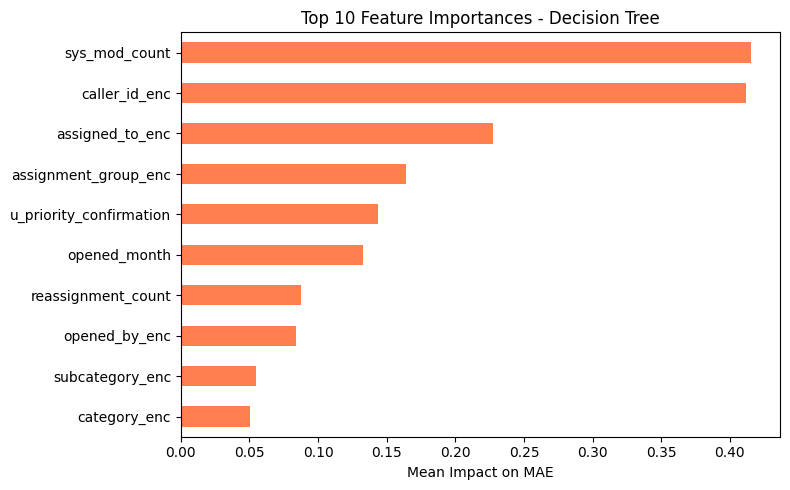


 Permutation Importance for SVR


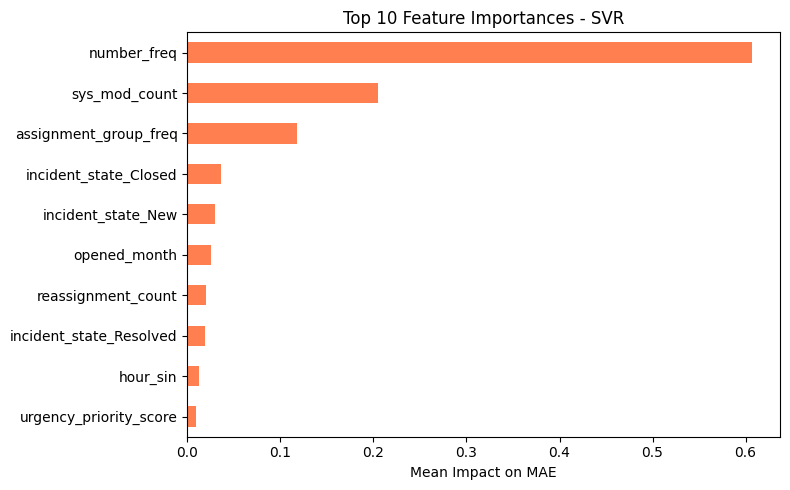


 Permutation Importance for MLP


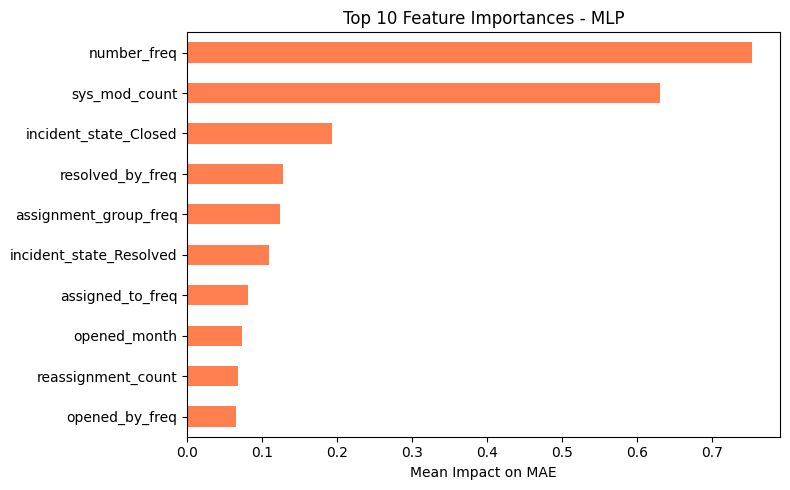

In [7]:
# Save results
comparison_df = pd.DataFrame(results)[['name', 'mae', 'rmse', 'r2']]
comparison_df = pd.DataFrame(results)[['name', 'mae', 'rmse', 'r2']]
print("\n📊 Model Evaluation Metrics Summary:")
display(comparison_df)


# Permutation Importance
for r in results:
    print(f"\n Permutation Importance for {r['name']}")
    result = permutation_importance(r['model'], r['X_test'], r['y_test'],
                                    scoring='neg_mean_absolute_error', n_repeats=10,
                                    random_state=42, n_jobs=-1)
    importances = pd.Series(result.importances_mean, index=r['X_test'].columns)
    top10 = importances.abs().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8, 5))
    top10.plot(kind='barh', color='coral')
    plt.gca().invert_yaxis()
    plt.title(f"Top 10 Feature Importances - {r['name']}")
    plt.xlabel("Mean Impact on MAE")
    plt.tight_layout()
    plt.show()


### 🔍 Top 10 Feature Importances – Cross-Model Comparison

#### Decision Tree
- **`sys_mod_count`** and **`caller_id_enc`** are the most influential features, each having a high impact on reducing MAE.
- Other important features include **`assigned_to_enc`**, **`assignment_group_enc`**, and **`opened_month`**, indicating the importance of who was involved and when the incident was opened.

#### SVR (Linear)
- **`number_freq`** stands out with the **highest impact** on MAE, suggesting that frequency-based patterns are critical for support ticket resolution.
- Other relevant features include **`sys_mod_count`**, **`assignment_group_freq`**, and incident state indicators like **`incident_state_Closed`**.

#### MLP (Neural Network)
- Similar to SVR, **`number_freq`** and **`sys_mod_count`** dominate as the most impactful.
- Frequency-encoded features like **`resolved_by_freq`**, **`assigned_to_freq`**, and **`assignment_group_freq`** play a key role.
- The importance of temporal (`opened_month`) and workflow-based (`incident_state_Resolved`) features suggests that MLP captures a richer pattern.

---

### Takeaway
> All models consistently identified **`sys_mod_count`** and frequency-based user/group involvement features as key predictors.  
> This indicates that how often an incident is modified, and who handles it, are strong indicators of how long it will take to resolve.
